In [1]:
# %curl -L -o data/archive.zip https://www.kaggle.com/api/v1/datasets/download/saldenisov/recipenlg

In [21]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np

In [3]:
df = pd.read_csv("full_dataset.csv") # read in recipesdata/dataset/full_dataset.csv

In [39]:
dfsm = df[:50000]

In [40]:
dfsm

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
...,...,...,...,...,...,...,...
49995,49995,Caramel Frosting,"[""2 sticks butter"", ""2 c. sugar"", ""1 c. milk""]","[""Let butter melt; add sugar and brown."", ""Add...",www.cookbooks.com/Recipe-Details.aspx?id=271824,Gathered,"[""butter"", ""sugar"", ""milk""]"
49996,49996,Barbecued Chicken Wings,"[""20 to 30 chicken wings"", ""1 (28 oz.) bottle ...","[""Mix sauce, brown sugar, onion and water"", ""m...",www.cookbooks.com/Recipe-Details.aspx?id=285631,Gathered,"[""chicken"", ""barbecue sauce"", ""brown sugar"", ""..."
49997,49997,Pound Cake,"[""3 sticks butter, beaten"", ""6 eggs"", ""4 c. se...","[""Bake at 275\u00b0 for 1 1/2 hours."", ""Put to...",www.cookbooks.com/Recipe-Details.aspx?id=1020555,Gathered,"[""butter"", ""eggs"", ""flour"", ""confectioners sug..."
49998,49998,Slush,"[""1 3/4 c. sugar"", ""2 c. boiling water"", ""5 ma...","[""Combine sugar and boiling water."", ""Stir and...",www.cookbooks.com/Recipe-Details.aspx?id=599562,Gathered,"[""sugar"", ""boiling water"", ""bananas"", ""orange ..."


In [41]:
dfsm["NER"] = dfsm["NER"].apply(lambda x: eval(x))

/tmp/ipykernel_49344/2207603067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsm["NER"] = dfsm["NER"].apply(lambda x: eval(x))


In [42]:
# Ensure the 'NER' column is of type object (string) and handle missing values
dfsm['NER'] = dfsm['NER'].astype(str)  # Convert all values to strings
dfsm['NER'] = dfsm['NER'].apply(eval)  # Convert string representations of lists back to lists

# Explode the 'NER' column to transform each list into multiple rows
exploded_series = dfsm['NER'].explode()

# Use vectorized string operations to clean the data
# .str.strip() removes leading/trailing whitespace
# .str.lower() converts strings to lowercase
# .dropna() removes any NaN values that may result from invalid entries
cleaned_series = exploded_series.str.strip().str.lower().dropna()

# Extract unique values and convert to a set
ings = set(cleaned_series.unique())

/tmp/ipykernel_49344/2790213498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsm['NER'] = dfsm['NER'].astype(str)  # Convert all values to strings
/tmp/ipykernel_49344/2790213498.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsm['NER'] = dfsm['NER'].apply(eval)  # Convert string representations of lists back to lists


In [43]:
print(len(ings))
reuse_fact = len(dfsm) / len(ings)
reuse_fact

10028


4.98603909054647

In [44]:
ings = list(ings) 
len(ings)

10028

In [10]:
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v1') # this is too big
# model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
# model = SentenceTransformer('sentence-transformers/static-similarity-mrl-multilingual-v1')
# model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# model = SentenceTransformer('OrdalieTech/Solon-embeddings-large-0.1')
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')




modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [45]:
X = embeddings = model.encode(ings, batch_size=50, show_progress_bar=True)
print(X.shape)

Batches:   0%|          | 0/201 [00:00<?, ?it/s]

(10028, 768)


In [46]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

eps=0.10, min_samples=2: clusters=0, noise=10028
eps=0.10, min_samples=3: clusters=0, noise=10028
eps=0.10, min_samples=4: clusters=0, noise=10028
eps=0.24, min_samples=2: clusters=41, noise=9946
eps=0.24, min_samples=3: clusters=0, noise=10028
eps=0.24, min_samples=4: clusters=0, noise=10028
eps=0.37, min_samples=2: clusters=129, noise=9764
eps=0.37, min_samples=3: clusters=4, noise=10014
eps=0.37, min_samples=4: clusters=0, noise=10028
eps=0.51, min_samples=2: clusters=305, noise=9385
eps=0.51, min_samples=3: clusters=23, noise=9949
eps=0.51, min_samples=4: clusters=5, noise=10007
eps=0.64, min_samples=2: clusters=528, noise=8866
eps=0.64, min_samples=3: clusters=64, noise=9794
eps=0.64, min_samples=4: clusters=17, noise=9937
eps=0.78, min_samples=2: clusters=765, noise=8205
eps=0.78, min_samples=3: clusters=156, noise=9423
eps=0.78, min_samples=4: clusters=45, noise=9767
eps=0.91, min_samples=2: clusters=1033, noise=7324
eps=0.91, min_samples=3: clusters=285, noise=8820
eps=0.91, mi

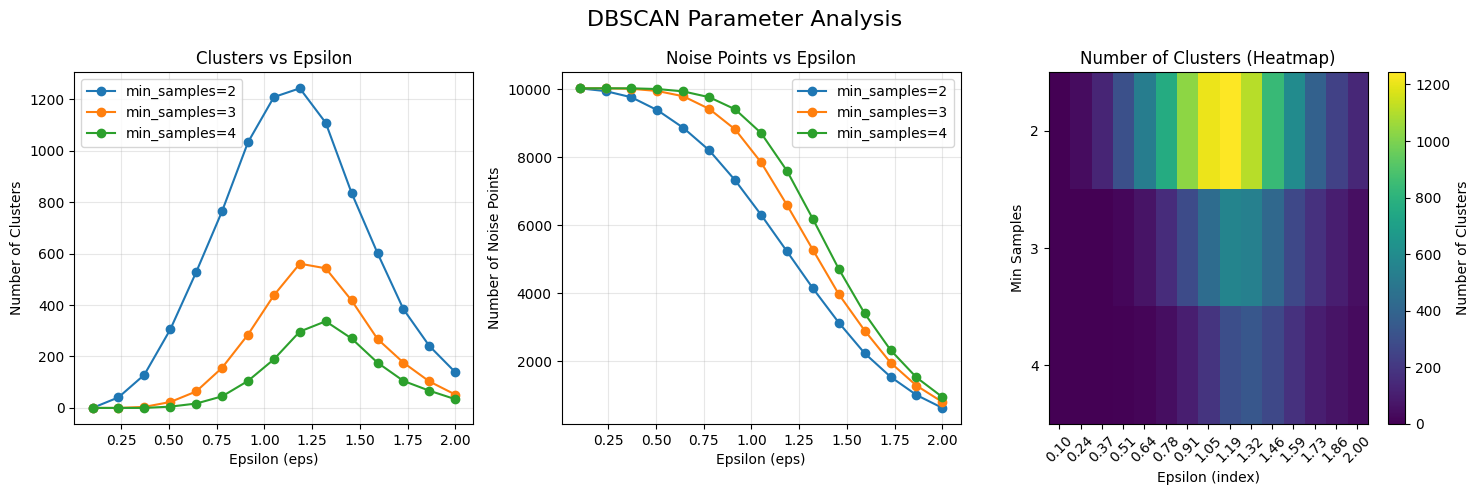


Summary Table:
Epsilon    Min Samples  Clusters   Noise     
------------------------------------------------------------
0.100      2            0          10028     
0.100      3            0          10028     
0.100      4            0          10028     
0.236      2            41         9946      
0.236      3            0          10028     
0.236      4            0          10028     
0.371      2            129        9764      
0.371      3            4          10014     
0.371      4            0          10028     
0.507      2            305        9385      
0.507      3            23         9949      
0.507      4            5          10007     
0.643      2            528        8866      
0.643      3            64         9794      
0.643      4            17         9937      
0.779      2            765        8205      
0.779      3            156        9423      
0.779      4            45         9767      
0.914      2            1033       7324      
0.9

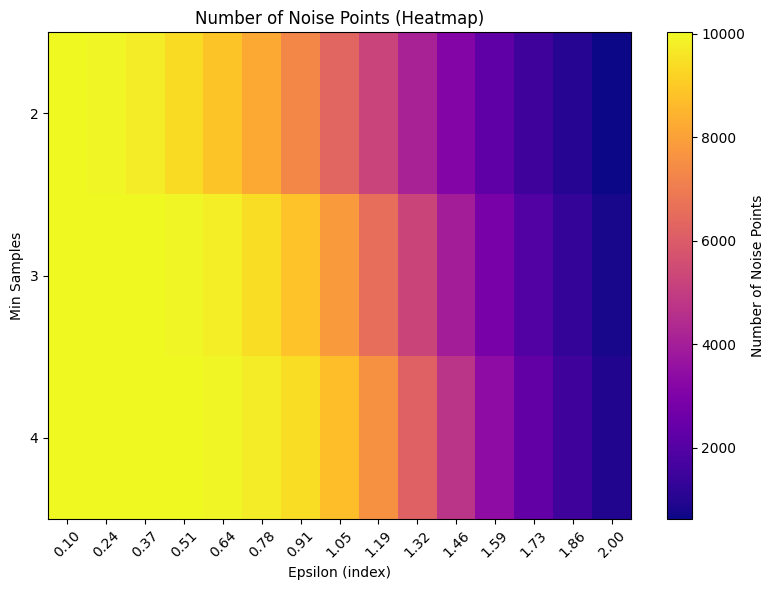

In [49]:


# Create epsilon values (10 combinations)
eps_values = np.linspace(0.1, 2.0, 15)  # Adjust range as needed for your data

# Create min_samples values
min_samples_values = [2, 3, 4]

# Store results
results = []

# Run DBSCAN for each combination
for eps, min_samples in product(eps_values, min_samples_values):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    results.append({
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'labels': labels.copy()  # Optional: store labels if needed later
    })
    
    print(f"eps={eps:.2f}, min_samples={min_samples}: "
          f"clusters={n_clusters}, noise={n_noise}")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('DBSCAN Parameter Analysis', fontsize=16)

# Plot 1: Number of clusters vs epsilon for each min_samples
for min_samples in min_samples_values:
    subset = [r for r in results if r['min_samples'] == min_samples]
    eps_vals = [r['eps'] for r in subset]
    clusters = [r['n_clusters'] for r in subset]
    
    axes[0].plot(eps_vals, clusters, 'o-', label=f'min_samples={min_samples}')
    
axes[0].set_xlabel('Epsilon (eps)')
axes[0].set_ylabel('Number of Clusters')
axes[0].set_title('Clusters vs Epsilon')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Number of noise points vs epsilon for each min_samples
for min_samples in min_samples_values:
    subset = [r for r in results if r['min_samples'] == min_samples]
    eps_vals = [r['eps'] for r in subset]
    noise = [r['n_noise'] for r in subset]
    
    axes[1].plot(eps_vals, noise, 'o-', label=f'min_samples={min_samples}')
    
axes[1].set_xlabel('Epsilon (eps)')
axes[1].set_ylabel('Number of Noise Points')
axes[1].set_title('Noise Points vs Epsilon')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Heatmap-style visualization
# Create a grid for the heatmap
min_samples_grid = np.array(min_samples_values)
eps_grid = eps_values

# Create meshgrid for plotting
X_grid, Y_grid = np.meshgrid(eps_grid, min_samples_grid)

# Prepare data for heatmap
clusters_grid = np.zeros((len(min_samples_values), len(eps_values)))
noise_grid = np.zeros((len(min_samples_values), len(eps_values)))

for i, min_samples in enumerate(min_samples_values):
    for j, eps in enumerate(eps_values):
        # Find matching result
        for r in results:
            if r['min_samples'] == min_samples and np.isclose(r['eps'], eps):
                clusters_grid[i, j] = r['n_clusters']
                noise_grid[i, j] = r['n_noise']
                break

# Plot clusters heatmap
im1 = axes[2].imshow(clusters_grid, aspect='auto', cmap='viridis')
axes[2].set_xlabel('Epsilon (index)')
axes[2].set_ylabel('Min Samples')
axes[2].set_title('Number of Clusters (Heatmap)')

# Set ticks
axes[2].set_xticks(range(len(eps_values)))
axes[2].set_xticklabels([f'{eps:.2f}' for eps in eps_values], rotation=45)
axes[2].set_yticks(range(len(min_samples_values)))
axes[2].set_yticklabels(min_samples_values)

# Add colorbar for heatmap
plt.colorbar(im1, ax=axes[2], label='Number of Clusters')

plt.tight_layout()
plt.show()

# Optional: Print summary table
print("\n" + "="*60)
print("Summary Table:")
print("="*60)
print(f"{'Epsilon':<10} {'Min Samples':<12} {'Clusters':<10} {'Noise':<10}")
print("-"*60)

for r in results:
    print(f"{r['eps']:<10.3f} {r['min_samples']:<12} {r['n_clusters']:<10} {r['n_noise']:<10}")

# Optional: Create a separate figure for noise heatmap
fig2, ax2 = plt.subplots(figsize=(8, 6))
im2 = ax2.imshow(noise_grid, aspect='auto', cmap='plasma')
ax2.set_xlabel('Epsilon (index)')
ax2.set_ylabel('Min Samples')
ax2.set_title('Number of Noise Points (Heatmap)')
ax2.set_xticks(range(len(eps_values)))
ax2.set_xticklabels([f'{eps:.2f}' for eps in eps_values], rotation=45)
ax2.set_yticks(range(len(min_samples_values)))
ax2.set_yticklabels(min_samples_values)
plt.colorbar(im2, ax=ax2, label='Number of Noise Points')
plt.tight_layout()
plt.show()

In [50]:

db = DBSCAN(eps=1.2, min_samples=2).fit(X) # X is the embedding vector
labels = db.labels_


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 1231
Estimated number of noise points: 5127


In [51]:
from collections import defaultdict
names = list(ings)

# Assuming `labels` is the output from DBSCAN and `names` is the list of ingredient names
# Example:
# labels = db.labels_
# names = list(ings)

# Group ingredients by their cluster labels
clusters = defaultdict(list)
for idx, label in enumerate(labels):
    clusters[label].append(names[idx])

# Print members of each cluster
for cluster_id, members in clusters.items():
    if cluster_id == -1:
        print(f"Noise Points (Unclustered): {len(members)} items")
    else:
        print(f"Cluster {cluster_id}: {len(members)} items")
    print(members)
    print("-" * 40)

# Print summary
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

Cluster 0: 4 items
['shredded monterrey jack cheese', 'sliced monterey jack cheese', 'shredded reduced fat monterey jack cheese', 'shredded monterey jack cheese']
----------------------------------------
Cluster 1: 16 items
['beef stew', 'stewing beef', 'stew beef', 'beef stew meat', 'very lean stew beef', 'stew meat', 'beef stew mix', 'lean stew beef', 'lean stewing meat beef', 'beef stew seasoning mix', 'lean stewing beef', 'lean stew meat', 'lean beef stew meat', 'lean stew', 'beef stew season mix', 'beef for stew']
----------------------------------------
Cluster 2: 3 items
['cubed ham', 'ham cubed', 'ham cubes']
----------------------------------------
Cluster 3: 4 items
['marshmallow creme', 'marshmallow crme', 'marshmallow crem', 'marshmallow cream']
----------------------------------------
Noise Points (Unclustered): 5127 items
['sauteing', 'gorgonzola cheese', 'child', 'guava pulp', 'refrigerator buttermilk', 'pickapeppa sauce', 'sweetened applesauce', 'heath chips', 'white ra

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# unique_labels = set(labels)
# core_samples_mask = np.zeros_like(labels, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True

# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = labels == k

#     xy = X[class_member_mask & core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=14,
#     )

#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=6,
#     )

# plt.title(f"Estimated number of clusters: {n_clusters_}")
# plt.show()

In [52]:
def simplify_clusters(clusters):
    """
    Collapses clusters into their simplest form.
    
    Args:
        clusters (dict): A dictionary where keys are cluster IDs and values are lists of ingredient names.
    
    Returns:
        dict: A mapping from each ingredient to its simplified form.
    """
    simplified_mapping = {}

    for cluster_id, ingredients in clusters.items():
        if cluster_id == -1:
            # Noise points (unclustered ingredients) are mapped to themselves
            for curr_ing in ingredients:
                simplified_mapping[curr_ing] = curr_ing
        else:
            # Find the simplest ingredient in the cluster (fewest words)
            simplest_ingredient = min(ingredients, key=lambda x: len(x.split()))
            # Map all ingredients in the cluster to the simplest form
            for ingredient in ingredients:
                simplified_mapping[ingredient] = simplest_ingredient

    return simplified_mapping

def simplify_ingredients(ingredients, mapping):
    """
    Simplifies a list of ingredients using a given mapping.
    
    Args:
        ingredients (list): A list of ingredient names.
        mapping (dict): A dictionary mapping original ingredients to their simplified forms.
    
    Returns:
        list: A new list of simplified ingredients.
    """
    return [mapping.get(ingredient, ingredient) for ingredient in ingredients]

In [53]:
simplified_mapping = simplify_clusters(clusters)
simplified_mapping

{'shredded monterrey jack cheese': 'shredded monterrey jack cheese',
 'sliced monterey jack cheese': 'shredded monterrey jack cheese',
 'shredded reduced fat monterey jack cheese': 'shredded monterrey jack cheese',
 'shredded monterey jack cheese': 'shredded monterrey jack cheese',
 'beef stew': 'beef stew',
 'stewing beef': 'beef stew',
 'stew beef': 'beef stew',
 'beef stew meat': 'beef stew',
 'very lean stew beef': 'beef stew',
 'stew meat': 'beef stew',
 'beef stew mix': 'beef stew',
 'lean stew beef': 'beef stew',
 'lean stewing meat beef': 'beef stew',
 'beef stew seasoning mix': 'beef stew',
 'lean stewing beef': 'beef stew',
 'lean stew meat': 'beef stew',
 'lean beef stew meat': 'beef stew',
 'lean stew': 'beef stew',
 'beef stew season mix': 'beef stew',
 'beef for stew': 'beef stew',
 'cubed ham': 'cubed ham',
 'ham cubed': 'cubed ham',
 'ham cubes': 'cubed ham',
 'marshmallow creme': 'marshmallow creme',
 'marshmallow crme': 'marshmallow creme',
 'marshmallow crem': 'marsh

In [17]:
# for i in range(10):
#   print(dfsm["NER"][i])
#   print(simplify_ingredients(dfsm["NER"][i], simplified_mapping))
#   print("----------------")



In [54]:
# create a new column and apply
dfsm["NER_Simple"] = dfsm["NER"].apply(lambda x: simplify_ingredients(x, simplified_mapping))

/tmp/ipykernel_49344/1550908580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsm["NER_Simple"] = dfsm["NER"].apply(lambda x: simplify_ingredients(x, simplified_mapping))


In [55]:
dfsm

,Unnamed: 0,title,ingredients,directions,link,source,NER,NER_Simple
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[brown sugar, milk, vanilla, nuts, butter, bit...","[brown sugar, milk, vanilla, nuts, butter, bit..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[beef, chicken breasts, cream of mushroom soup...","[beef-flavor, chicken breasts, mushroom soup, ..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[frozen corn, cream cheese, butter, garlic pow...","[frozen corn, cream frosting, butter, powdered..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[chicken, chicken gravy, cream of mushroom sou...","[chicken, chicken gravy, mushroom soup, shredd..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[peanut butter, graham cracker crumbs, butter,...","[peanut butter, cracklings, butter, powdered s..."
...,...,...,...,...,...,...,...,...
49995,49995,Caramel Frosting,"[""2 sticks butter"", ""2 c. sugar"", ""1 c. milk""]","[""Let butter melt; add sugar and brown."", ""Add...",www.cookbooks.com/Recipe-Details.aspx?id=271824,Gathered,"[butter, sugar, milk]","[butter, sugar, milk]"
49996,49996,Barbecued Chicken Wings,"[""20 to 30 chicken wings"", ""1 (28 oz.) bottle ...","[""Mix sauce, brown sugar, onion and water"", ""m...",www.cookbooks.com/Recipe-Details.aspx?id=285631,Gathered,"[chicken, barbecue sauce, brown sugar, onion, ...","[chicken, barbecue sauce, brown sugar, onion, ..."
49997,49997,Pound Cake,"[""3 sticks butter, beaten"", ""6 eggs"", ""4 c. se...","[""Bake at 275\u00b0 for 1 1/2 hours."", ""Put to...",www.cookbooks.com/Recipe-Details.aspx?id=1020555,Gathered,"[butter, eggs, flour, confectioners sugar, lem...","[butter, eggs, farina, confectionary sugar, le..."
49998,49998,Slush,"[""1 3/4 c. sugar"", ""2 c. boiling water"", ""5 ma...","[""Combine sugar and boiling water."", ""Stir and...",www.cookbooks.com/Recipe-Details.aspx?id=599562,Gathered,"[sugar, boiling water, bananas, orange juice, ...","[sugar, boiling water, bananas, orange juice, ..."


In [56]:
dfsm.to_csv("simplified_dataset.csv")